In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anomaly-detection/Submission.csv
/kaggle/input/anomaly-detection/train.csv
/kaggle/input/anomaly-detection/test.csv


# Exploratory Data analysis.

In [2]:
trainDf=pd.read_csv("/kaggle/input/anomaly-detection/train.csv")
print(trainDf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   15830 non-null  int64  
 1   value       15830 non-null  int64  
 2   is_anomaly  15830 non-null  bool   
 3   predicted   15830 non-null  float64
dtypes: bool(1), float64(1), int64(2)
memory usage: 386.6 KB
None


In [3]:
trainDf.head()

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


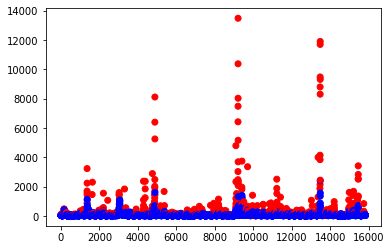

In [4]:
import matplotlib.pyplot as plt
#plt.scatter(trainDf['value'],trainDf[]['predicted'])
colors = np.where(trainDf["is_anomaly"]==False,'b','r')
plt.scatter(range(15830),trainDf['value'],c=colors)

Plotted the values versus index graph for the training dataset. In general higher values correspond to higher probabilities of being anomaly.

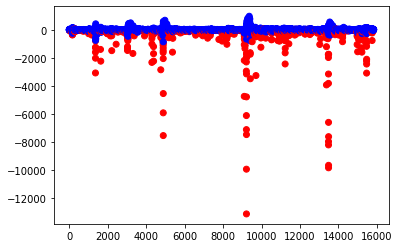

In [5]:
plt.scatter(range(15830),(trainDf['predicted']-trainDf['value']),c=colors)

It is reasonable to assume that the anomalous values would have significant deviation in predicted and actual than compared to the non-anomalous values. The plot suggests that in the training dataset the anomalous values have predicted value < actual value. This might not hold on the test dataset in general and adjusting our model to consider absolute deviations seems to be a reasonable idea. Further plots also reveal that the distribution of training and test dataset might actually be pretty different. 

In [6]:
trainDf.sort_values('timestamp').head()

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


In [7]:
trainDf.value_counts('value')

value
29       259
21       252
33       251
30       251
26       245
        ... 
543        1
241        1
237        1
554        1
13479      1
Length: 631, dtype: int64

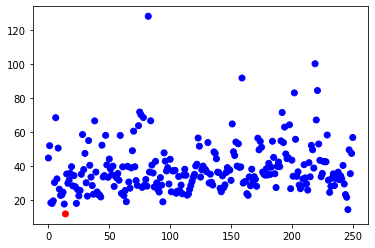

In [8]:
anomCol=[]
for i in range(15830):
    if trainDf['value'][i]==30:
        if trainDf['is_anomaly'][i]:
            anomCol.append('r')
        else:
            anomCol.append('b')
plt.scatter(range(251),trainDf[trainDf['value']==30]['predicted'],c=anomCol)

Plotting predicted vs index plot for a fixed actual value of 30.The plot is surprising intuitively because of single anomaly(near predicted<20) however the topmost point is NOT AN ANOMALY despite the large deviation.

In [9]:
trainDf[trainDf['value']==30].head(85)

,timestamp,value,is_anomaly,predicted
31,1425017873,30,False,44.719856
36,1425019373,30,False,51.963814
85,1425034073,30,False,18.330496
89,1425035273,30,False,17.930708
91,1425035873,30,False,19.451230
...,...,...,...,...
4624,1426395773,30,False,32.028670
4708,1426420973,30,False,28.113440
5155,1426555073,30,False,128.268700
5214,1426572773,30,False,36.429480


In [10]:
trainDf.value_counts('is_anomaly')

is_anomaly
False    15054
True       776
dtype: int64

In [11]:
trainDf.head(10)

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160
5,1425010073,27,False,27.713638
6,1425010373,37,False,41.545710
7,1425010673,36,False,38.743620
8,1425010973,49,False,40.859787
9,1425011273,36,False,25.444733


In [12]:
trainDf['value'].unique()

array([   42,    41,    61,    44,    27,    37,    36,    49,    32,
          50,    43,    47,    45,    56,    40,    57,    73,    59,
         140,    38,    28,    30,    31,    26,    20,    23,    15,
          25,    19,    18,    21,    17,    11,    13,    22,    14,
          16,    24,    29,    10,    39,    34,    35,    53,   222,
          46,   110,    65,    54,    66,   102,    92,    62,    86,
          67,    58,    52,    51,    68,   109,    80,   108,   172,
         271,   456,   440,   477,   426,   284,   159,   112,   118,
          70,    63,   105,    95,   111,   116,   155,   141,   115,
         137,   113,   136,   119,    97,   101,    96,    87,    93,
         103,    99,    90,   154,   131,   130,   100,   122,    89,
         106,   138,   123,   120,    88,   147,   129,    81,    85,
         114,    60,    91,    78,    74,    77,    83,    79,    76,
          98,   104,   117,   107,   204,   229,    82,     7,     9,
          12,     8,

In [13]:
trainDf['value']-trainDf['predicted']

0        -2.072500
1        -9.709390
2       -40.405120
3        21.049633
4         8.649840
           ...    
15825    -9.624115
15826   -14.752296
15827    -4.147630
15828   -32.007545
15829   -21.144700
Length: 15830, dtype: float64

In [14]:
trainDf.corr()

,timestamp,value,is_anomaly,predicted
timestamp,1.000000,0.032628,0.016457,0.030462
value,0.032628,1.000000,0.324859,0.445180
is_anomaly,0.016457,0.324859,1.000000,0.059719
predicted,0.030462,0.445180,0.059719,1.000000


# Model fitting

In [15]:
points=[]
y=[]
for i in range(15830):
    curr=[trainDf['value'][i],abs(trainDf['predicted'][i]-trainDf['value'][i])]
    points.append(curr)
    if trainDf['is_anomaly'][i]==False:
        y.append(0)
    else:
        y.append(1)
from sklearn import svm
clf=svm.SVC(class_weight={0:4,1:95})
clf.fit(points,y)

SVC(class_weight={0: 4, 1: 95})

I decided to go for an Support Vector Machine classifier. due to the disparity between the training and test dataset(for e.g. the max value in test dataset is 80) KNN appears to be a pretty bad choice. 

Further we apply SVM on a feature mapping of actual,abs(predValue-actual) because this particular choice exposes the anomalies better than (actual,predicted) as we saw in the Exploratory data analysis. 

Here we are dealing with an imbalanced dataset i.e the training samples have very few anomalies and a large number of normal datapoints therefore it is neccessary to provide weights to the SVM classifier because we are more interested in anomalies. The weights are assigned in inverse of the ratio of counts of anomaly and not anomaly respectively. 

In [16]:
clf.predict([[20,100],[140,65]])

array([1, 1])

In [17]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, points, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.921


In [18]:
from sklearn.metrics import f1_score
print(f1_score(y,clf.predict(points)))

0.3579406156360665


# Test dataset analysis

In [19]:
testDf=pd.read_csv("/kaggle/input/anomaly-detection/test.csv")
print(testDf.head())

    timestamp  value  predicted
0  1396332000   20.0       20.0
1  1396332300   20.0       20.0
2  1396332600   20.0       20.0
3  1396332900   20.0       20.0
4  1396333200   20.0       20.0


In [20]:
print(testDf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3960 non-null   int64  
 1   value      3960 non-null   float64
 2   predicted  3960 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 92.9 KB
None


In [21]:
ans=[]
for i in range(3960):
    curr=[testDf['timestamp'][i]]
    is_anom=clf.predict([[testDf['value'][i],abs(testDf['predicted'][i]-testDf['value'][i])]])
    if is_anom==0:
        curr.append(False)
    else:
        curr.append(True)
    ans.append(curr)
ansDf=pd.DataFrame(ans,columns=['timestamp','is_anomaly'])

Ran the SVM model on the test dataset.

In [22]:
ansDf.head()
ansDf.value_counts('is_anomaly')

is_anomaly
False    3869
True       91
dtype: int64

In [23]:
ansDf.to_csv("answer.csv",index=False)

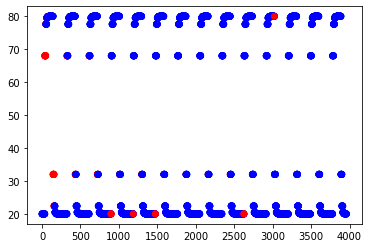

In [24]:
colors = np.where(ansDf["is_anomaly"]==False,'b','r')
plt.scatter(range(3960),testDf['value'],c=colors)

The test dataset has PERIODIC VALUES!!!. 

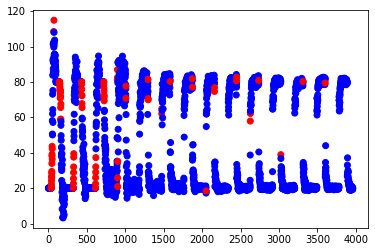

In [25]:
plt.scatter(range(3960),testDf['predicted'],c=colors)

The predicted values are not so periodic but they do have a the similar structuring.

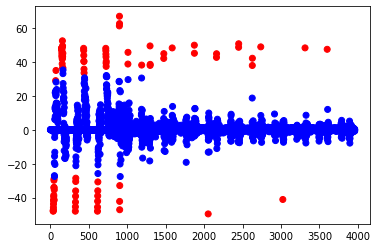

In [26]:
colors = np.where(ansDf["is_anomaly"]==False,'b','r')
plt.scatter(range(3960),(testDf['predicted']-testDf['value']),c=colors)

In [27]:
again we see a prominent line at y=0. the anomalies predicted by our model seem pretty reasonable

SyntaxError: invalid syntax (<ipython-input-27-28073a22eed2>, line 1)

In [28]:
testDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3960 non-null   int64  
 1   value      3960 non-null   float64
 2   predicted  3960 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 92.9 KB


In [29]:
testDf.value_counts('value')

value
20.000000    1440
20.003840     168
20.019200     168
20.096000     168
20.480000     168
22.399999     168
31.999994     168
68.000000     168
77.600000     168
79.520000     168
79.904000     168
79.980800     168
79.996160     168
79.999232     168
79.999846     168
79.999969     168
dtype: int64

The periodic dataset has only few finite values repeating in it.

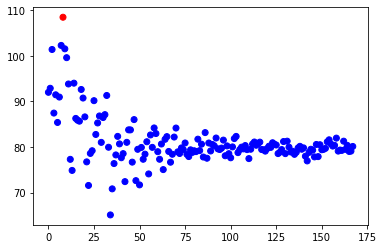

In [30]:
colors = []
N=79.52
for i in range(3960):
    if ansDf['is_anomaly'][i]==False and np.isclose(testDf['value'][i],N):
        colors.append('b')
    elif ansDf['is_anomaly'][i]==True and np.isclose(testDf['value'][i],N):
        colors.append('r')
#colors=getOutliers(20.003840)

plt.scatter(range(168),testDf[np.isclose(testDf['value'],N)]['predicted'],c=colors)


for one fixed value we get the index vs predicted value plot.

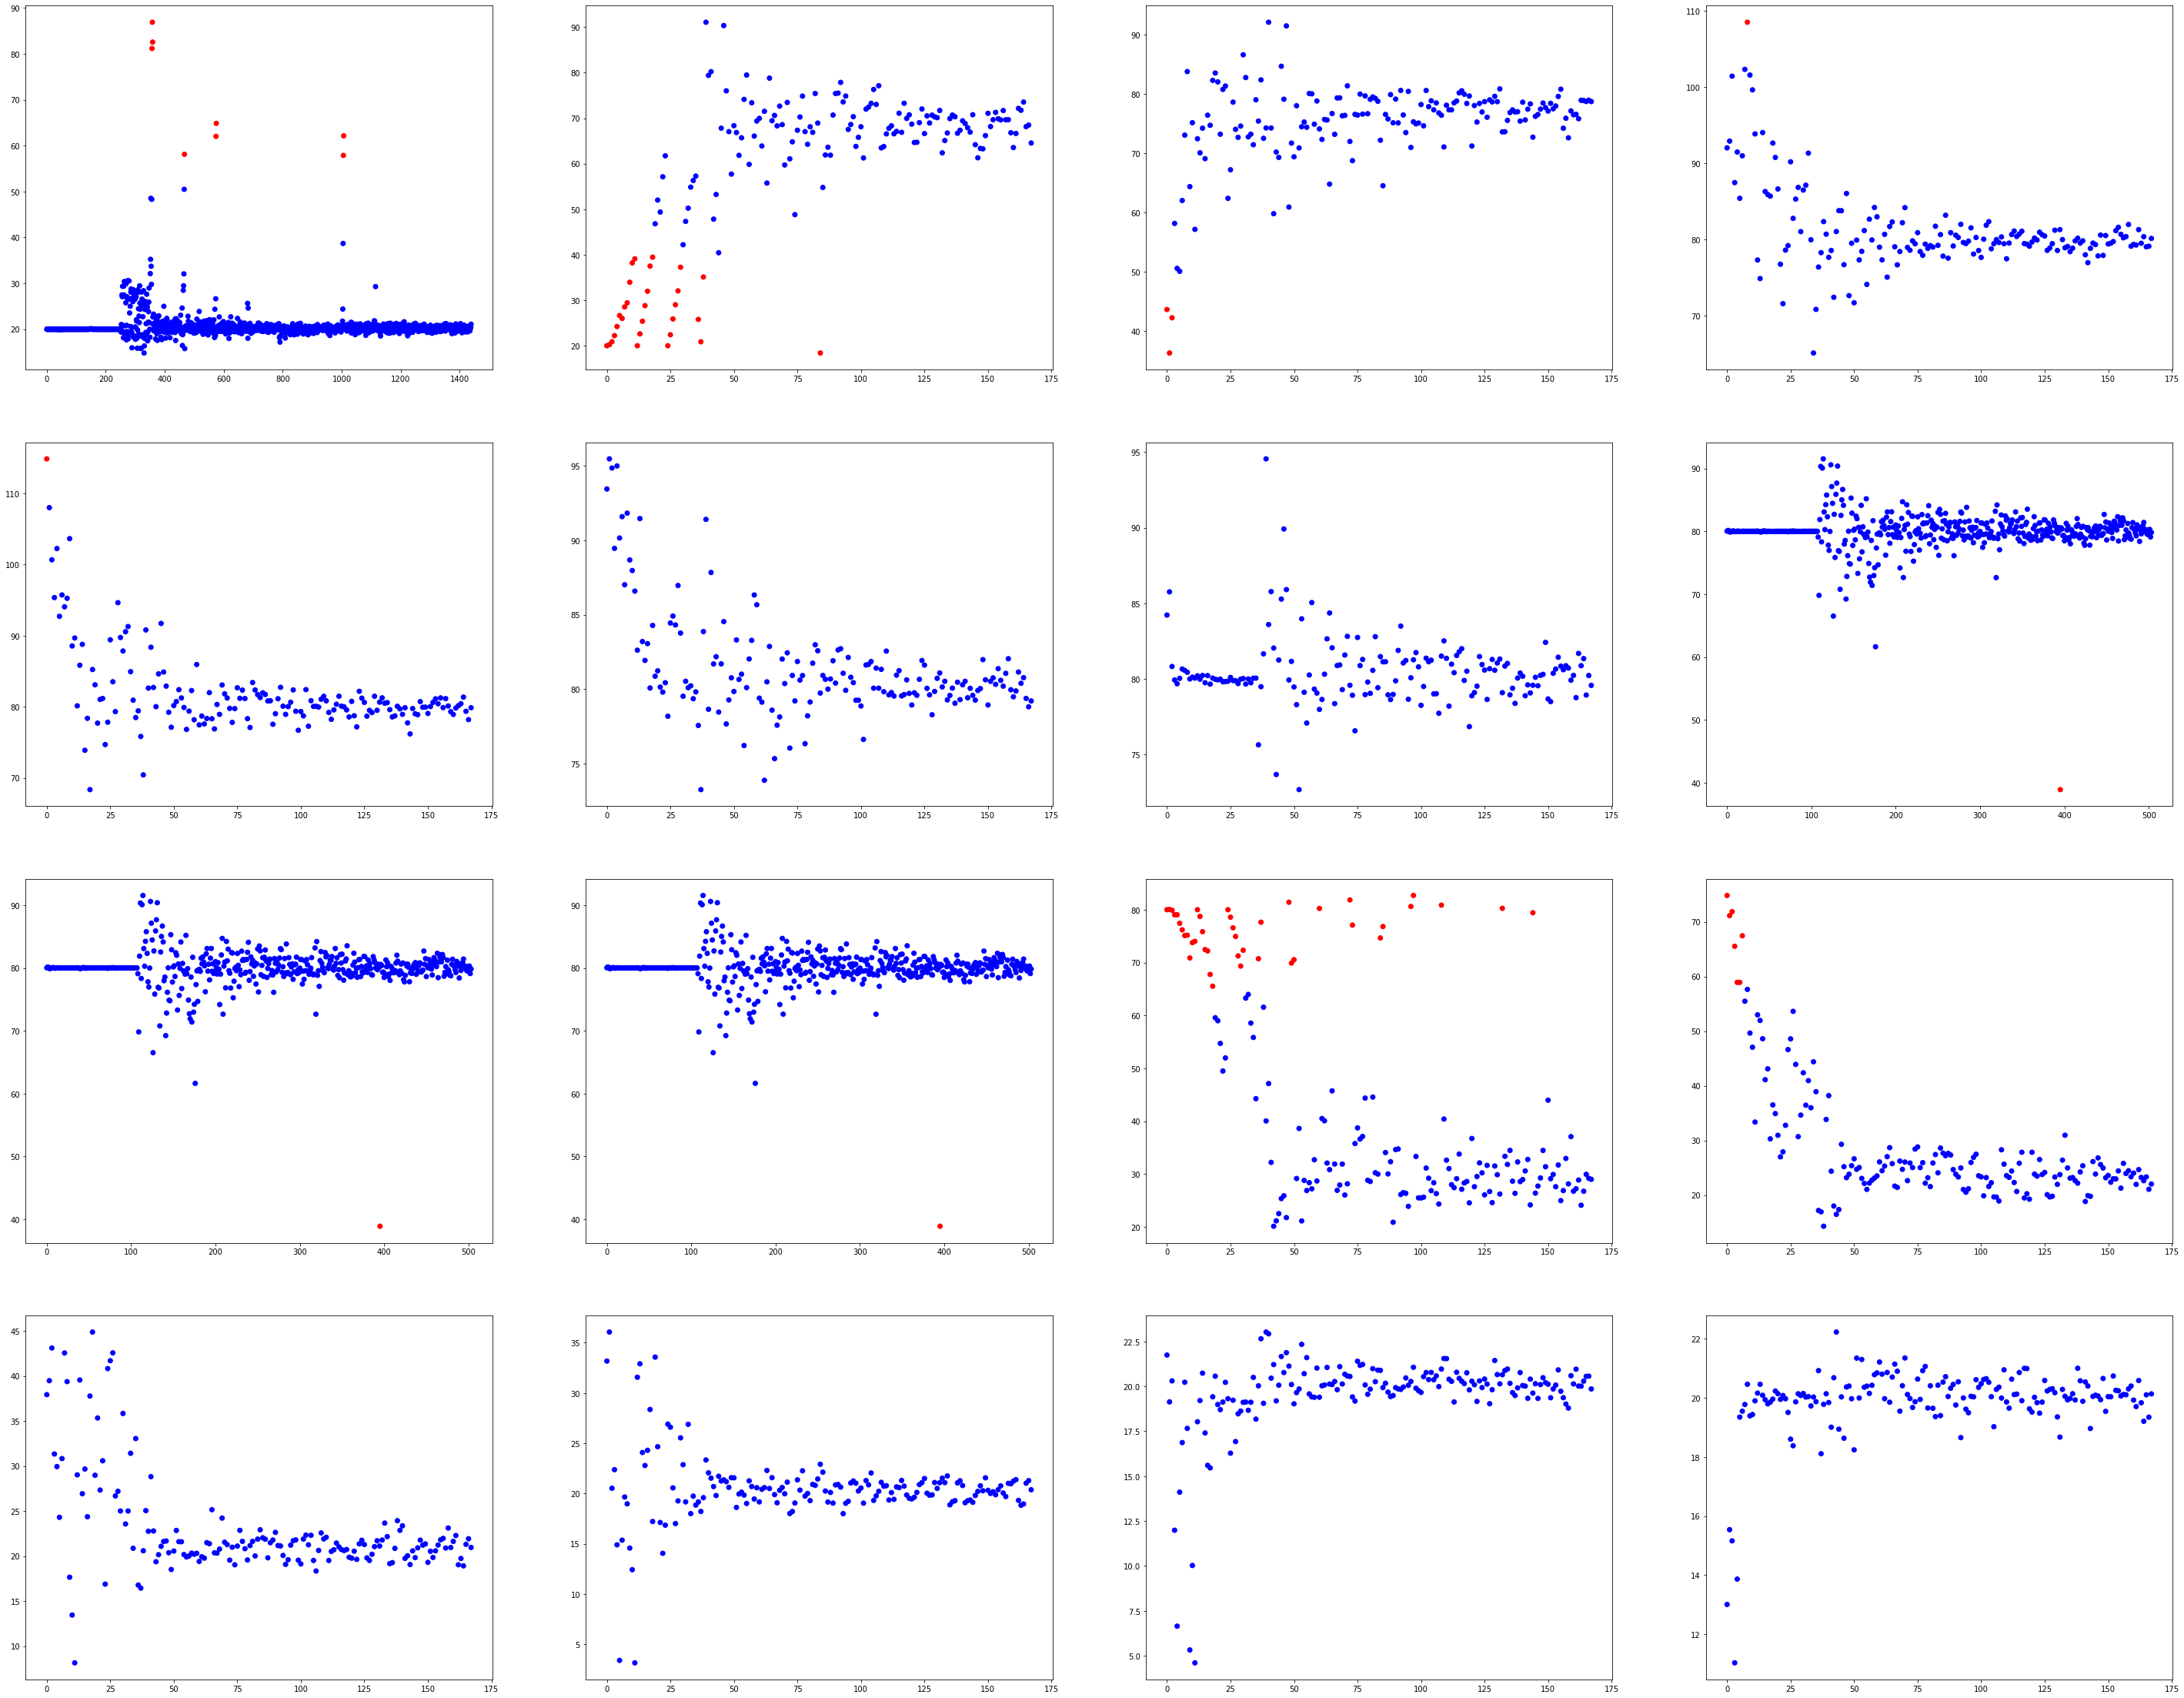

In [31]:
cnt=0
fig, axs=plt.subplots(4,4,figsize=(50,40))
for N in testDf['value'].unique():
    colors = []
    #plt.subplot(4,4,cnt)
    for i in range(3960):
        if ansDf['is_anomaly'][i]==False and np.isclose(testDf['value'][i],N):
            colors.append('b')
        elif ansDf['is_anomaly'][i]==True and np.isclose(testDf['value'][i],N):
            colors.append('r')
    #colors=getOutliers(20.003840)
    
    axs[cnt//4,cnt%4].scatter(range(len(colors)),testDf[np.isclose(testDf['value'],N)]['predicted'],c=colors)
    cnt+=1

We do it for all values. The anomalies predicted by our model look pretty reasonable except perhaps the last few graphs were the bottom most points are still blue.

In [32]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
def getOutliers(N):
    colors=[]
    vals=[]
    inds=[]
    for i in range(3960):
        if np.isclose(testDf['value'][i],N):
            vals.append([testDf['predicted'][i]])
            inds.append(i)
    lof=LocalOutlierFactor(n_neighbors=30)
    clf=IsolationForest()
    pred=lof.fit_predict(vals)
    #pred=clf.fit_predict(vals)
    sz=len(pred)
    for i in pred:
        if i==1:
            ansDf.loc[inds[i],'is_anomaly']=False
            colors.append('b')
        else:
            ansDf.loc[inds[i],'is_anomaly']=True
            colors.append('r')
    return colors

This code uses the unsupervised learning models to get anomalies. I tested it and the results were not so good however this is good enough for verifying our models.

In [33]:
ansDf.to_csv("answer.csv",index=False)